# Create Custom Neural Network to Detect Blurred Images
The idea is to create a simple NN trained to recognize blurred images by detecting edges in the figures

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

### Import training and test sets 

In [10]:
#import training set
from keras.preprocessing import image
from os import listdir
from keras import utils

fdir='Data/CERTH_ImageBlurDataset/TrainingSet/Naturally-Blurred/'
files= listdir(fdir)
X=[] #feature vector
images_train=[]
Y=[] #class vector (1='blurred', 0='in focus')
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images_train.append(x)
    x=image.img_to_array(x)
    X.append(x)
    Y.append(int(1))
    
fdir='Data/CERTH_ImageBlurDataset/TrainingSet/Undistorted/'
files= listdir(fdir)
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images_train.append(x)
    x=image.img_to_array(x)
    X.append(x)
    Y.append(int(0))
    
X_train = np.array(X)
y_train = utils.to_categorical(Y, 2)

In [11]:
#get test set labels
import pandas as pd
fn='Data/CERTH_ImageBlurDataset/EvaluationSet/NaturalBlurSet.xlsx'
xl = np.array(pd.read_excel(fn))
val={}
for xx in xl:
    val[xx[0]]=xx[1]

In [12]:
#import test set
fdir='Data/CERTH_ImageBlurDataset/EvaluationSet/NaturalBlurSet/'
files= listdir(fdir)
X_test=[] #feature vector
images_test=[]
y_true=[] #class vector (1='blurred', 0='in focus')
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images_test.append(x)
    x=image.img_to_array(x)
    X_test.append(x)
    y_true.append((val[fn[:-4]]+1)/2)
    
X_test = np.array(X_test)
y_test = utils.to_categorical(y_true, 2)

### Create the model

In [647]:
def set_filter(kernel1, kernel2):
    kernels, b = model.get_weights()
    kernels[:,:,0,0] = kernel1
    kernels[:,:,0,1] = kernel2
    model.set_weights([kernels, b])

In [18]:
horizontal_edge = [[0, 1., 0],
                   [0, -1., 0],
                   [0, 0, 0]]
vertical_edge = [[0, 0, 0],
                 [1, -1., 0],
                 [0, 0, 0]]
vertical_sobel_edge = [[1., 0., -1.],
                   [2., 0., -2.],
                   [1., 0, -1.]]
horizontal_sobel_edge = [[1., 2., 1.],
                 [0, 0., 0],
                 [-1., -2., -1.]]

In [607]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, SeparableConv2D

model = Sequential()
model.add(Conv2D(2, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))

set_filter(horizontal_sobel_edge, vertical_sobel_edge)


In [608]:
n_train=10
X_conv=[]
for it in range(n_train):
    X_conv.append(model.predict(np.array(X_train)[it:it+1,:,:,0:3]))

X_conv=np.array(X_conv)
X_conv=X_conv.reshape(n_train,222,222,2)


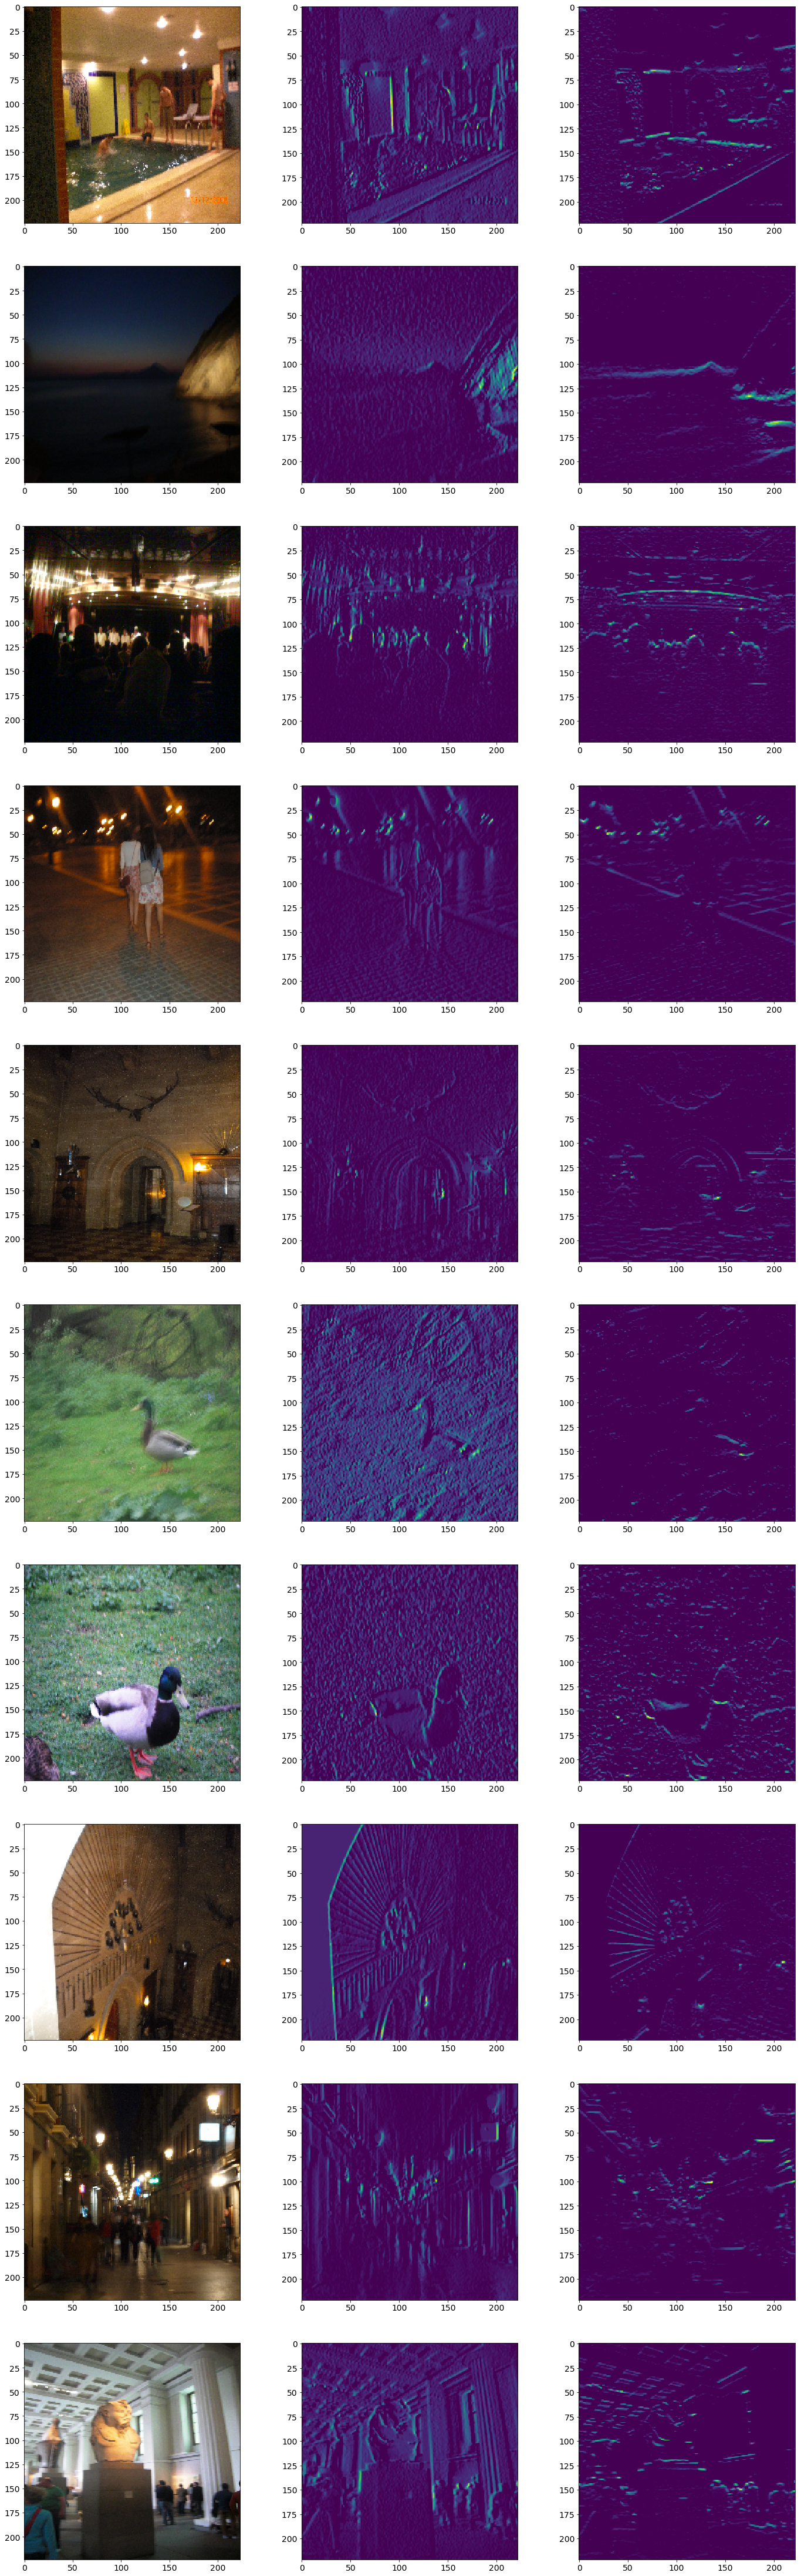

In [609]:
fig, axs = plt.subplots(n_train, 3, figsize=(8*3, 8*n_examples))
for n, (ax1, ax2, ax3) in enumerate(axs):
    ax1.imshow(images_train[n])
    ax2.imshow(X_conv[n,:,:,0])
    ax3.imshow(X_conv[n,:,:,1])

# Learning... 

In [ ]:
#Split training and validation test
from keras import utils
from sklearn.model_selection import train_test_split
X_train__, X_val__, y_train__, y_val__ = train_test_split(X_train, y_train,
                                                  test_size=0.3,
                                                  random_state=99)

X_train__=np.array(X_train__)
X_val__=np.array(X_val__)

### NN with edge recognition

In [15]:
def set_filter(kernel1, kernel2):
    kernels, b = model.get_weights()[0:2]
    kernels[:,:,0,0] = kernel1
    kernels[:,:,1,0] = kernel1
    kernels[:,:,2,0] = kernel1
    kernels[:,:,0,1] = kernel2
    kernels[:,:,1,1] = kernel2
    kernels[:,:,2,1] = kernel2
    model.set_weights([kernels, b])

In [97]:
#Run with only the final dense layer
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization

inputs = Input(shape=(224,224,3))
x = Conv2D(2, (3,3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
set_filter(horizontal_sobel_edge, vertical_sobel_edge)

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'],)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 222, 222, 2)       56        
_________________________________________________________________
batch_normalization_27 (Batc (None, 222, 222, 2)       8         
_________________________________________________________________
flatten_27 (Flatten)         (None, 98568)             0         
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 197138    
Total params: 197,202
Trainable params: 197,198
Non-trainable params: 4
_________________________________________________________________
None


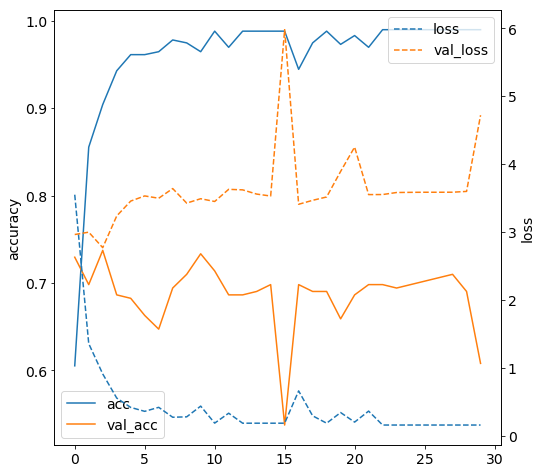

In [98]:
history_callback=model.fit(X_train__, y_train__,
                  epochs=30,
                  verbose=False,
                  validation_data=(X_val__, y_val__))

df = pd.DataFrame(history_callback.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
df[['loss', 'val_loss']].plot(linestyle='--', ax=plt.twinx())
plt.ylabel("loss");

In [26]:
testset_test=model.evaluate(X_test,y_test)
print('test_acc =\t{}\ttest_loss=\t{}'.format(round(testset_test[1],3),round(testset_test[0],3)))

1000/1000 [==============================] - 7s 7ms/step
test_acc =	0.689	test_loss=	3.524


In [39]:
train_acc=history_callback.history['acc'][-1]
train_loss=history_callback.history['loss'][-1]
val_acc=history_callback.history['val_acc'][-1]
val_loss=history_callback.history['val_loss'][-1]
print('train_acc =\t{}\ttrain_loss=\t{}\nval_acc =\t{}\tval_loss=\t{}\ntest_acc =\t{}\ttest_loss=\t{}'.format(round(train_acc,3),round(train_loss,3),round(val_acc,3),round(val_loss,3),round(testset_test[1],3),round(testset_test[0],3)))

train_acc =	0.976	train_loss=	0.377
val_acc =	0.682	val_loss=	3.998
test_acc =	0.689	test_loss=	3.524


In [99]:
#Train on the whole training set and test on the test set
history_callback=model.fit(X_train, y_train,
                  epochs=30,
                  verbose=False,
                    )
testset_test=model.evaluate(X_test,y_test)
print('test_acc =\t{}\ttest_loss=\t{}'.format(round(testset_test[1],3),round(testset_test[0],3)))

1000/1000 [==============================] - 7s 7ms/step
test_acc =	0.684	test_loss=	4.266


### NN with edge recognition and multiple dense layers

In [92]:
#Run with only the final dense layer
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization

inputs = Input(shape=(224,224,3))
x = Conv2D(2, (3,3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
set_filter(horizontal_sobel_edge, vertical_sobel_edge)

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'],)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 222, 222, 2)       56        
_________________________________________________________________
batch_normalization_25 (Batc (None, 222, 222, 2)       8         
_________________________________________________________________
flatten_25 (Flatten)         (None, 98568)             0         
_________________________________________________________________
dense_69 (Dense)             (None, 30)                2957070   
_________________________________________________________________
dense_70 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_71 (Dense)             (None, 30)                930       
__________

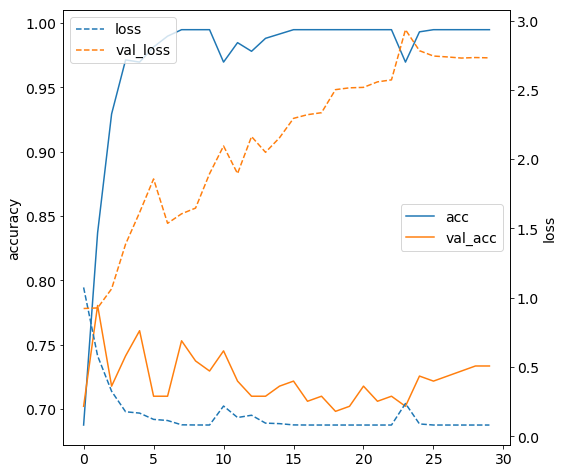

In [42]:
history_callback=model.fit(X_train__, y_train__,
                  epochs=30,
                  verbose=False,
                  validation_data=(X_val__, y_val__))

df = pd.DataFrame(history_callback.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
df[['loss', 'val_loss']].plot(linestyle='--', ax=plt.twinx())
plt.ylabel("loss");

In [43]:
testset_test=model.evaluate(X_test,y_test)
print('test_acc =\t{}\ttest_loss=\t{}'.format(round(testset_test[1],3),round(testset_test[0],3)))

1000/1000 [==============================] - 7s 7ms/step
test_acc =	0.705	test_loss=	2.625


In [44]:
train_acc=history_callback.history['acc'][-1]
train_loss=history_callback.history['loss'][-1]
val_acc=history_callback.history['val_acc'][-1]
val_loss=history_callback.history['val_loss'][-1]
print('train_acc =\t{}\ttrain_loss=\t{}\nval_acc =\t{}\tval_loss=\t{}\ntest_acc =\t{}\ttest_loss=\t{}'.format(round(train_acc,3),round(train_loss,3),round(val_acc,3),round(val_loss,3),round(testset_test[1],3),round(testset_test[0],3)))

train_acc =	0.995	train_loss=	0.081
val_acc =	0.733	val_loss=	2.731
test_acc =	0.705	test_loss=	2.625


In [93]:
#Train on the whole training set and test on the test set
history_callback=model.fit(X_train, y_train,
                  epochs=30,
                  verbose=False,
                    )
testset_test=model.evaluate(X_test,y_test)
print('test_acc =\t{}\ttest_loss=\t{}'.format(round(testset_test[1],3),round(testset_test[0],3)))

1000/1000 [==============================] - 8s 8ms/step
test_acc =	0.681	test_loss=	3.146


### NN with normal convolution

In [ ]:
# 1. Optimization Convolution Layers

In [61]:
#Create grid search, create layers with random number of nodes between 2 and 100
import random

ConvGrid={}
it=0
m0list=[2,5,10]
m1list=[None,5]
m2list=[None,10]

for m2 in m2list:
    for m1 in m1list:
        for m0 in m0list[:]:
            ConvGrid[it]={'combinations':[m0,m1,m2],
                      'train_acc':None,
                      'train_loss':None,
                      'val_acc':None,
                      'val_loss':None,
                      'test_acc':None,
                      'test_loss':None
                     }
            it=it+1

In [66]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization

for it in range(len(ConvGrid)):
    m0,m1,m2=ConvGrid[it]['combinations']

    inputs = Input(shape=(224,224,3))
    x = Conv2D(m0, (3,3), activation='relu')(inputs)
    if m1 != None:
        x = Conv2D(m1, (3,3), activation='relu')(x)
    if m2 != None:
        x = Conv2D(m2, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='RMSprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],)

    history_callback=model.fit(X_train__, y_train__,
                                batch_size=128,
                                epochs=15,
                                verbose=False,
                                validation_data=(X_val__, y_val__))

    scores=model.evaluate(X_test, y_test)
    train_acc=round(history_callback.history['acc'][-1],3)
    val_acc=round(history_callback.history['val_acc'][-1],3)
    
    
    ConvGrid[it]['train_acc']=round(history_callback.history['acc'][-1],3)
    ConvGrid[it]['train_loss']=round(history_callback.history['loss'][-1],3)
    ConvGrid[it]['val_acc']=round(history_callback.history['val_acc'][-1],3)
    ConvGrid[it]['val_loss']=round(history_callback.history['val_loss'][-1],3)
    ConvGrid[it]['test_acc']=round(scores[1],3)
    ConvGrid[it]['test_loss']=round(scores[0],3)
    print('{},{},{}: train_acc={} val_acc={} test_acc={}'.format(m0,m1,m2,train_acc,val_acc,scores[1]))

1000/1000 [==============================] - 7s 7ms/step
2,None,None: train_acc=0.85 val_acc=0.761 test_acc=0.654
1000/1000 [==============================] - 8s 8ms/step
5,None,None: train_acc=0.818 val_acc=0.667 test_acc=0.575
1000/1000 [==============================] - 10s 10ms/step
10,None,None: train_acc=0.877 val_acc=0.745 test_acc=0.592


KeyboardInterrupt: 

Optimization run on Keras, restus:

2,None,None: train_acc=0.928 val_acc=0.643 test_acc=0.658 <br>

5,None,None: train_acc=0.768 val_acc=0.718 test_acc=0.613 <br>

10,None,None: train_acc=0.743 val_acc=0.71 test_acc=0.573 <br>

2,5,None: train_acc=0.923 val_acc=0.475 test_acc=0.571 <br>

5,5,None: train_acc=0.818 val_acc=0.765 test_acc=0.656 <br>

10,5,None: train_acc=0.941 val_acc=0.745 test_acc=0.642 <br>

2,None,10: train_acc=0.768 val_acc=0.718 test_acc=0.581 <br>

5,None,10: train_acc=0.765 val_acc=0.722 test_acc=0.588 <br>

10,None,10: train_acc=0.745 val_acc=0.733 test_acc=0.589 <br>

__2,5,10: train_acc=0.798 val_acc=0.769 test_acc=0.654__ <br>

5,5,10: train_acc=0.753 val_acc=0.733 test_acc=0.592 <br>

10,5,10: train_acc=0.852 val_acc=0.553 test_acc=0.509 <br>



In [ ]:
# 2. Optimization Dense Layers

In [67]:
#Create grid search, create layers with random number of nodes between 2 and 100
import random

DenseGrid={}
it=0
m0list=[random.randint(2,100),random.randint(2,100)]
m1list=[None,random.randint(2,100)]
m2list=[None,random.randint(2,100)]
m3list=[None,random.randint(2,100)]
m4list=[None,random.randint(2,100)]
m5list=[None,random.randint(2,100)]
m6list=[None,random.randint(2,100)]
m7list=[None,random.randint(2,100)]

for m7 in m7list:
    for m6 in m6list:
        for m5 in m5list:
            for m4 in m4list:
                for m3 in m3list:
                    for m2 in m2list:
                        for m1 in m1list:
                            for m0 in m0list[:]:
                                DenseGrid[it]={'combinations':[m0,m1,m2,m3,m4,m5,m6,m7],
                                          'train_acc':None,
                                          'train_loss':None,
                                          'val_acc':None,
                                          'val_loss':None,
                                          'test_acc':None,
                                          'test_loss':None
                                         }
                                it=it+1

In [71]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization

for it in range(len(DenseGrid)):
    m0,m1,m2,m3,m4,m5,m6,m7=DenseGrid[it]['combinations']

    inputs = Input(shape=(224,224,3))
    x = Conv2D(2, (3,3), activation='relu')(inputs)
    x = Conv2D(5, (3,3), activation='relu')(x)
    x = Conv2D(10, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(m0, activation='relu')(x)
    if m1 != None:
        x = Dense(m1, activation='relu')(x)
    if m2 != None:
        x = Dense(m2, activation='relu')(x)
    if m3 != None:
        x = Dense(m3, activation='relu')(x)
    if m4 != None:
        x = Dense(m4, activation='relu')(x)
    if m5 != None:
        x = Dense(m5, activation='relu')(x)
    if m6 != None:
        x = Dense(m6, activation='relu')(x)
    if m7 != None:
        x = Dense(m7, activation='relu')(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='RMSprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'],)


    history_callback=model.fit(X_train__, y_train__,
                                batch_size=128,
                                epochs=15,
                                verbose=False,
                                validation_data=(X_val__, y_val__))

    scores=model.evaluate(X_test, y_test)
    train_acc=round(history_callback.history['acc'][-1],3)
    val_acc=round(history_callback.history['val_acc'][-1],3)
    
    DenseGrid[it]['train_acc']=round(history_callback.history['acc'][-1],3)
    DenseGrid[it]['train_loss']=round(history_callback.history['loss'][-1],3)
    DenseGrid[it]['val_acc']=round(history_callback.history['val_acc'][-1],3)
    DenseGrid[it]['val_loss']=round(history_callback.history['val_loss'][-1],3)
    DenseGrid[it]['test_acc']=round(scores[1],3)
    DenseGrid[it]['test_loss']=round(scores[0],3)
    print('{},{},{},{},{},{},{}: train_acc={} val_acc={} test_acc={}'.format(m0,m1,m2,m3,m4,m5,m6,m7,train_acc,val_acc,scores[1]))

1000/1000 [==============================] - 20s 20ms/step
95,None,None,None,None,None,None: train_acc=None val_acc=0.681 test_acc=0.725
1000/1000 [==============================] - 19s 19ms/step
96,None,None,None,None,None,None: train_acc=None val_acc=0.75 test_acc=0.729
1000/1000 [==============================] - 18s 18ms/step
95,35,None,None,None,None,None: train_acc=None val_acc=0.765 test_acc=0.733
1000/1000 [==============================] - 18s 18ms/step
96,35,None,None,None,None,None: train_acc=None val_acc=0.776 test_acc=0.745
1000/1000 [==============================] - 18s 18ms/step
95,None,54,None,None,None,None: train_acc=None val_acc=0.746 test_acc=0.718
1000/1000 [==============================] - 18s 18ms/step
96,None,54,None,None,None,None: train_acc=None val_acc=0.739 test_acc=0.753
1000/1000 [==============================] - 18s 18ms/step
95,35,54,None,None,None,None: train_acc=None val_acc=0.745 test_acc=0.729
1000/1000 [==============================] - 18s 18ms/

In [73]:
#Part of the optimization done in Kaggle

DenseGrid={0: {'combinations': [61, None, None, None, None, None, None, None], 'train_acc': 0.76, 'train_loss': 3.853, 'val_acc': 0.702, 'val_loss': 4.729, 'test_acc': 0.574, 'test_loss': 6.827}, 1: {'combinations': [7, None, None, None, None, None, None, None], 'train_acc': 0.874, 'train_loss': 0.822, 'val_acc': 0.733, 'val_loss': 1.99, 'test_acc': 0.587, 'test_loss': 2.011}, 2: {'combinations': [61, 88, None, None, None, None, None, None], 'train_acc': 0.891, 'train_loss': 1.672, 'val_acc': 0.769, 'val_loss': 3.554, 'test_acc': 0.618, 'test_loss': 5.923}, 3: {'combinations': [7, 88, None, None, None, None, None, None], 'train_acc': 0.968, 'train_loss': 0.213, 'val_acc': 0.573, 'val_loss': 1.778, 'test_acc': 0.595, 'test_loss': 1.939}, 4: {'combinations': [61, None, 21, None, None, None, None, None], 'train_acc': 0.745, 'train_loss': 4.095, 'val_acc': 0.733, 'val_loss': 4.275, 'test_acc': 0.59, 'test_loss': 6.573}, 5: {'combinations': [7, None, 21, None, None, None, None, None], 'train_acc': 0.958, 'train_loss': 0.583, 'val_acc': 0.741, 'val_loss': 1.195, 'test_acc': 0.711, 'test_loss': 1.532}, 6: {'combinations': [61, 88, 21, None, None, None, None, None], 'train_acc': 0.857, 'train_loss': 2.256, 'val_acc': 0.706, 'val_loss': 4.671, 'test_acc': 0.603, 'test_loss': 6.104}, 7: {'combinations': [7, 88, 21, None, None, None, None, None], 'train_acc': 0.835, 'train_loss': 0.55, 'val_acc': 0.663, 'val_loss': 0.637, 'test_acc': 0.592, 'test_loss': 0.906}, 8: {'combinations': [61, None, None, 50, None, None, None, None], 'train_acc': 0.753, 'train_loss': 3.96, 'val_acc': 0.729, 'val_loss': 4.302, 'test_acc': 0.581, 'test_loss': 6.694}, 9: {'combinations': [7, None, None, 50, None, None, None, None], 'train_acc': 0.939, 'train_loss': 0.255, 'val_acc': 0.686, 'val_loss': 0.829, 'test_acc': 0.565, 'test_loss': 0.862}, 10: {'combinations': [61, 88, None, 50, None, None, None, None], 'train_acc': 0.775, 'train_loss': 3.555, 'val_acc': 0.714, 'val_loss': 4.535, 'test_acc': 0.586, 'test_loss': 6.575}, 11: {'combinations': [7, 88, None, 50, None, None, None, None], 'train_acc': 0.965, 'train_loss': 0.091, 'val_acc': 0.702, 'val_loss': 0.676, 'test_acc': 0.603, 'test_loss': 0.781}, 12: {'combinations': [61, None, 21, 50, None, None, None, None], 'train_acc': 0.766, 'train_loss': 3.725, 'val_acc': 0.631, 'val_loss': 5.794, 'test_acc': 0.551, 'test_loss': 7.046}, 13: {'combinations': [7, None, 21, 50, None, None, None, None], 'train_acc': 0.914, 'train_loss': 0.553, 'val_acc': 0.741, 'val_loss': 0.859, 'test_acc': 0.698, 'test_loss': 1.055}, 14: {'combinations': [61, 88, 21, 50, None, None, None, None], 'train_acc': 0.993, 'train_loss': 0.108, 'val_acc': 0.753, 'val_loss': 1.111, 'test_acc': 0.703, 'test_loss': 1.515}, 15: {'combinations': [7, 88, 21, 50, None, None, None, None], 'train_acc': 0.971, 'train_loss': 0.101, 'val_acc': 0.745, 'val_loss': 1.969, 'test_acc': 0.723, 'test_loss': 2.348}, 16: {'combinations': [61, None, None, None, 25, None, None, None], 'train_acc': 0.741, 'train_loss': 4.124, 'val_acc': 0.698, 'val_loss': 4.841, 'test_acc': 0.591, 'test_loss': 6.543}, 17: {'combinations': [7, None, None, None, 25, None, None, None], 'train_acc': 0.933, 'train_loss': 0.353, 'val_acc': 0.812, 'val_loss': 1.211, 'test_acc': 0.784, 'test_loss': 1.465}, 18: {'combinations': [61, 88, None, None, 25, None, None, None], 'train_acc': 0.83, 'train_loss': 2.699, 'val_acc': 0.424, 'val_loss': 9.241, 'test_acc': 0.47, 'test_loss': 8.471}, 19: {'combinations': [7, 88, None, None, 25, None, None, None], 'train_acc': 0.939, 'train_loss': 0.492, 'val_acc': 0.424, 'val_loss': 5.842, 'test_acc': 0.492, 'test_loss': 5.42}, 20: {'combinations': [61, None, 21, None, 25, None, None, None], 'train_acc': 0.751, 'train_loss': 3.987, 'val_acc': 0.733, 'val_loss': 4.275, 'test_acc': 0.586, 'test_loss': 6.601}, 21: {'combinations': [7, None, 21, None, 25, None, None, None], 'train_acc': 0.953, 'train_loss': 0.293, 'val_acc': 0.776, 'val_loss': 0.885, 'test_acc': 0.732, 'test_loss': 1.284}, 22: {'combinations': [61, 88, 21, None, 25, None, None, None], 'train_acc': 0.817, 'train_loss': 0.515, 'val_acc': 0.733, 'val_loss': 4.275, 'test_acc': 0.589, 'test_loss': 6.588}, 23: {'combinations': [7, 88, 21, None, 25, None, None, None], 'train_acc': 0.953, 'train_loss': 0.166, 'val_acc': 0.643, 'val_loss': 1.886, 'test_acc': 0.713, 'test_loss': 1.752}, 24: {'combinations': [61, None, None, 50, 25, None, None, None], 'train_acc': 0.975, 'train_loss': 0.405, 'val_acc': 0.753, 'val_loss': 1.227, 'test_acc': 0.747, 'test_loss': 1.241}, 25: {'combinations': [7, None, None, 50, 25, None, None, None], 'train_acc': 0.854, 'train_loss': 0.758, 'val_acc': 0.639, 'val_loss': 0.773, 'test_acc': 0.61, 'test_loss': 1.023}, 26: {'combinations': [61, 88, None, 50, 25, None, None, None], 'train_acc': 0.976, 'train_loss': 0.377, 'val_acc': 0.749, 'val_loss': 2.043, 'test_acc': 0.72, 'test_loss': 2.513}, 27: {'combinations': [7, 88, None, 50, 25, None, None, None], 'train_acc': 0.861, 'train_loss': 0.474, 'val_acc': 0.498, 'val_loss': 0.659, 'test_acc': 0.537, 'test_loss': 0.89}, 28: {'combinations': [61, None, 21, 50, 25, None, None, None], 'train_acc': 0.933, 'train_loss': 0.516, 'val_acc': 0.62, 'val_loss': 1.049, 'test_acc': 0.603, 'test_loss': 0.935}, 29: {'combinations': [7, None, 21, 50, 25, None, None, None], 'train_acc': 0.958, 'train_loss': 0.142, 'val_acc': 0.725, 'val_loss': 1.037, 'test_acc': 0.671, 'test_loss': 1.16}, 30: {'combinations': [61, 88, 21, 50, 25, None, None, None], 'train_acc': 0.938, 'train_loss': 0.489, 'val_acc': 0.62, 'val_loss': 3.08, 'test_acc': 0.648, 'test_loss': 2.818}, 31: {'combinations': [7, 88, 21, 50, 25, None, None, None], 'train_acc': 0.998, 'train_loss': 0.027, 'val_acc': 0.714, 'val_loss': 1.635, 'test_acc': 0.67, 'test_loss': 1.979}, 32: {'combinations': [61, None, None, None, None, 49, None, None], 'train_acc': 0.845, 'train_loss': 2.448, 'val_acc': 0.718, 'val_loss': 4.392, 'test_acc': 0.562, 'test_loss': 6.832}, 33: {'combinations': [7, None, None, None, None, 49, None, None], 'train_acc': 0.776, 'train_loss': 3.583, 'val_acc': 0.718, 'val_loss': 4.437, 'test_acc': 0.595, 'test_loss': 6.338}, 34: {'combinations': [61, 88, None, None, None, 49, None, None], 'train_acc': 0.829, 'train_loss': 2.739, 'val_acc': 0.533, 'val_loss': 7.4, 'test_acc': 0.559, 'test_loss': 7.01}, 35: {'combinations': [7, 88, None, None, None, 49, None, None], 'train_acc': 0.901, 'train_loss': 0.438, 'val_acc': 0.675, 'val_loss': 0.961, 'test_acc': 0.666, 'test_loss': 1.149}, 36: {'combinations': [61, None, 21, None, None, 49, None, None], 'train_acc': 0.976, 'train_loss': 0.378, 'val_acc': 0.737, 'val_loss': 1.763, 'test_acc': 0.738, 'test_loss': 1.719}, 37: {'combinations': [7, None, 21, None, None, 49, None, None], 'train_acc': 0.968, 'train_loss': 0.317, 'val_acc': 0.667, 'val_loss': 1.89, 'test_acc': 0.677, 'test_loss': 1.892}, 38: {'combinations': [61, 88, 21, None, None, 49, None, None], 'train_acc': 0.84, 'train_loss': 0.629, 'val_acc': 0.733, 'val_loss': 4.275, 'test_acc': 0.589, 'test_loss': 6.588}, 39: {'combinations': [7, 88, 21, None, None, 49, None, None], 'train_acc': 0.886, 'train_loss': 0.334, 'val_acc': 0.698, 'val_loss': 0.748, 'test_acc': 0.702, 'test_loss': 0.912}, 40: {'combinations': [61, None, None, 50, None, 49, None, None], 'train_acc': 0.745, 'train_loss': 4.095, 'val_acc': 0.733, 'val_loss': 4.275, 'test_acc': 0.589, 'test_loss': 6.588}, 41: {'combinations': [7, None, None, 50, None, 49, None, None], 'train_acc': 0.77, 'train_loss': 0.739, 'val_acc': 0.725, 'val_loss': 0.78, 'test_acc': 0.589, 'test_loss': 1.038}, 42: {'combinations': [61, 88, None, 50, None, 49, None, None], 'train_acc': 0.931, 'train_loss': 0.353, 'val_acc': 0.431, 'val_loss': 6.048, 'test_acc': 0.532, 'test_loss': 5.087}, 43: {'combinations': [7, 88, None, 50, None, 49, None, None], 'train_acc': 0.877, 'train_loss': 0.289, 'val_acc': 0.514, 'val_loss': 2.074, 'test_acc': 0.56, 'test_loss': 2.106}, 44: {'combinations': [61, None, 21, 50, None, 49, None, None], 'train_acc': 0.966, 'train_loss': 0.471, 'val_acc': 0.631, 'val_loss': 3.405, 'test_acc': 0.659, 'test_loss': 3.177}, 45: {'combinations': [7, None, 21, 50, None, 49, None, None], 'train_acc': 0.938, 'train_loss': 0.271, 'val_acc': 0.749, 'val_loss': 0.629, 'test_acc': 0.74, 'test_loss': 1.042}, 46: {'combinations': [61, 88, 21, 50, None, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 47: {'combinations': [7, 88, 21, 50, None, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 48: {'combinations': [61, None, None, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 49: {'combinations': [7, None, None, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 50: {'combinations': [61, 88, None, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 51: {'combinations': [7, 88, None, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 52: {'combinations': [61, None, 21, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 53: {'combinations': [7, None, 21, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 54: {'combinations': [61, 88, 21, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 55: {'combinations': [7, 88, 21, None, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 56: {'combinations': [61, None, None, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 57: {'combinations': [7, None, None, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 58: {'combinations': [61, 88, None, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 59: {'combinations': [7, 88, None, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 60: {'combinations': [61, None, 21, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 61: {'combinations': [7, None, 21, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 62: {'combinations': [61, 88, 21, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 63: {'combinations': [7, 88, 21, 50, 25, 49, None, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 64: {'combinations': [61, None, None, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 65: {'combinations': [7, None, None, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 66: {'combinations': [61, 88, None, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 67: {'combinations': [7, 88, None, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 68: {'combinations': [61, None, 21, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 69: {'combinations': [7, None, 21, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 70: {'combinations': [61, 88, 21, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 71: {'combinations': [7, 88, 21, None, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 72: {'combinations': [61, None, None, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 73: {'combinations': [7, None, None, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 74: {'combinations': [61, 88, None, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 75: {'combinations': [7, 88, None, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 76: {'combinations': [61, None, 21, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 77: {'combinations': [7, None, 21, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 78: {'combinations': [61, 88, 21, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 79: {'combinations': [7, 88, 21, 50, None, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 80: {'combinations': [61, None, None, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 81: {'combinations': [7, None, None, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 82: {'combinations': [61, 88, None, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 83: {'combinations': [7, 88, None, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 84: {'combinations': [61, None, 21, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 85: {'combinations': [7, None, 21, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 86: {'combinations': [61, 88, 21, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 87: {'combinations': [7, 88, 21, None, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 88: {'combinations': [61, None, None, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 89: {'combinations': [7, None, None, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 90: {'combinations': [61, 88, None, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 91: {'combinations': [7, 88, None, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 92: {'combinations': [61, None, 21, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 93: {'combinations': [7, None, 21, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 94: {'combinations': [61, 88, 21, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 95: {'combinations': [7, 88, 21, 50, 25, None, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 96: {'combinations': [61, None, None, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 97: {'combinations': [7, None, None, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 98: {'combinations': [61, 88, None, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 99: {'combinations': [7, 88, None, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 100: {'combinations': [61, None, 21, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 101: {'combinations': [7, None, 21, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 102: {'combinations': [61, 88, 21, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 103: {'combinations': [7, 88, 21, None, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 104: {'combinations': [61, None, None, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 105: {'combinations': [7, None, None, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 106: {'combinations': [61, 88, None, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 107: {'combinations': [7, 88, None, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 108: {'combinations': [61, None, 21, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 109: {'combinations': [7, None, 21, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 110: {'combinations': [61, 88, 21, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 111: {'combinations': [7, 88, 21, 50, None, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 112: {'combinations': [61, None, None, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 113: {'combinations': [7, None, None, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 114: {'combinations': [61, 88, None, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 115: {'combinations': [7, 88, None, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 116: {'combinations': [61, None, 21, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 117: {'combinations': [7, None, 21, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 118: {'combinations': [61, 88, 21, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 119: {'combinations': [7, 88, 21, None, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 120: {'combinations': [61, None, None, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 121: {'combinations': [7, None, None, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 122: {'combinations': [61, 88, None, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 123: {'combinations': [7, 88, None, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 124: {'combinations': [61, None, 21, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 125: {'combinations': [7, None, 21, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 126: {'combinations': [61, 88, 21, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 127: {'combinations': [7, 88, 21, 50, 25, 49, 55, None], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 128: {'combinations': [61, None, None, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 129: {'combinations': [7, None, None, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 130: {'combinations': [61, 88, None, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 131: {'combinations': [7, 88, None, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 132: {'combinations': [61, None, 21, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 133: {'combinations': [7, None, 21, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 134: {'combinations': [61, 88, 21, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 135: {'combinations': [7, 88, 21, None, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 136: {'combinations': [61, None, None, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 137: {'combinations': [7, None, None, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 138: {'combinations': [61, 88, None, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 139: {'combinations': [7, 88, None, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 140: {'combinations': [61, None, 21, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 141: {'combinations': [7, None, 21, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 142: {'combinations': [61, 88, 21, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 143: {'combinations': [7, 88, 21, 50, None, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 144: {'combinations': [61, None, None, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 145: {'combinations': [7, None, None, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 146: {'combinations': [61, 88, None, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 147: {'combinations': [7, 88, None, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 148: {'combinations': [61, None, 21, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 149: {'combinations': [7, None, 21, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 150: {'combinations': [61, 88, 21, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 151: {'combinations': [7, 88, 21, None, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 152: {'combinations': [61, None, None, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 153: {'combinations': [7, None, None, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 154: {'combinations': [61, 88, None, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 155: {'combinations': [7, 88, None, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 156: {'combinations': [61, None, 21, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 157: {'combinations': [7, None, 21, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 158: {'combinations': [61, 88, 21, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 159: {'combinations': [7, 88, 21, 50, 25, None, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 160: {'combinations': [61, None, None, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 161: {'combinations': [7, None, None, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 162: {'combinations': [61, 88, None, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 163: {'combinations': [7, 88, None, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 164: {'combinations': [61, None, 21, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 165: {'combinations': [7, None, 21, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 166: {'combinations': [61, 88, 21, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 167: {'combinations': [7, 88, 21, None, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 168: {'combinations': [61, None, None, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 169: {'combinations': [7, None, None, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 170: {'combinations': [61, 88, None, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 171: {'combinations': [7, 88, None, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 172: {'combinations': [61, None, 21, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 173: {'combinations': [7, None, 21, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 174: {'combinations': [61, 88, 21, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 175: {'combinations': [7, 88, 21, 50, None, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 176: {'combinations': [61, None, None, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 177: {'combinations': [7, None, None, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 178: {'combinations': [61, 88, None, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 179: {'combinations': [7, 88, None, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 180: {'combinations': [61, None, 21, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 181: {'combinations': [7, None, 21, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 182: {'combinations': [61, 88, 21, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 183: {'combinations': [7, 88, 21, None, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 184: {'combinations': [61, None, None, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 185: {'combinations': [7, None, None, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 186: {'combinations': [61, 88, None, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 187: {'combinations': [7, 88, None, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 188: {'combinations': [61, None, 21, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 189: {'combinations': [7, None, 21, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 190: {'combinations': [61, 88, 21, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 191: {'combinations': [7, 88, 21, 50, 25, 49, None, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 192: {'combinations': [61, None, None, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 193: {'combinations': [7, None, None, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 194: {'combinations': [61, 88, None, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 195: {'combinations': [7, 88, None, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 196: {'combinations': [61, None, 21, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 197: {'combinations': [7, None, 21, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 198: {'combinations': [61, 88, 21, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 199: {'combinations': [7, 88, 21, None, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 200: {'combinations': [61, None, None, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 201: {'combinations': [7, None, None, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 202: {'combinations': [61, 88, None, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 203: {'combinations': [7, 88, None, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 204: {'combinations': [61, None, 21, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 205: {'combinations': [7, None, 21, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 206: {'combinations': [61, 88, 21, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 207: {'combinations': [7, 88, 21, 50, None, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 208: {'combinations': [61, None, None, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 209: {'combinations': [7, None, None, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 210: {'combinations': [61, 88, None, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 211: {'combinations': [7, 88, None, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 212: {'combinations': [61, None, 21, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 213: {'combinations': [7, None, 21, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 214: {'combinations': [61, 88, 21, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 215: {'combinations': [7, 88, 21, None, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 216: {'combinations': [61, None, None, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 217: {'combinations': [7, None, None, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 218: {'combinations': [61, 88, None, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 219: {'combinations': [7, 88, None, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 220: {'combinations': [61, None, 21, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 221: {'combinations': [7, None, 21, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 222: {'combinations': [61, 88, 21, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 223: {'combinations': [7, 88, 21, 50, 25, None, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 224: {'combinations': [61, None, None, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 225: {'combinations': [7, None, None, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 226: {'combinations': [61, 88, None, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 227: {'combinations': [7, 88, None, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 228: {'combinations': [61, None, 21, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 229: {'combinations': [7, None, 21, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 230: {'combinations': [61, 88, 21, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 231: {'combinations': [7, 88, 21, None, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 232: {'combinations': [61, None, None, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 233: {'combinations': [7, None, None, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 234: {'combinations': [61, 88, None, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 235: {'combinations': [7, 88, None, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 236: {'combinations': [61, None, 21, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 237: {'combinations': [7, None, 21, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 238: {'combinations': [61, 88, 21, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 239: {'combinations': [7, 88, 21, 50, None, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 240: {'combinations': [61, None, None, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 241: {'combinations': [7, None, None, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 242: {'combinations': [61, 88, None, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 243: {'combinations': [7, 88, None, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 244: {'combinations': [61, None, 21, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 245: {'combinations': [7, None, 21, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 246: {'combinations': [61, 88, 21, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 247: {'combinations': [7, 88, 21, None, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 248: {'combinations': [61, None, None, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 249: {'combinations': [7, None, None, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 250: {'combinations': [61, 88, None, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 251: {'combinations': [7, 88, None, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 252: {'combinations': [61, None, 21, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 253: {'combinations': [7, None, 21, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 254: {'combinations': [61, 88, 21, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}, 255: {'combinations': [7, 88, 21, 50, 25, 49, 55, 35], 'train_acc': None, 'train_loss': None, 'val_acc': None, 'val_loss': None, 'test_acc': None, 'test_loss': None}}

The optimizazion was done on Kaggle, by using from 1 to 8 layers each one with 25 nodes (due to limited amout of time for optimization). The results are the following:


25,None,None,None,None,None,None,None: train_acc=0.776 val_acc=0.741 test_acc=0.597 <br>
25,25,None,None,None,None,None,None: train_acc=0.776 val_acc=0.525 test_acc=0.481 <br>
25,25,25,None,None,None,None,None: train_acc=0.988 val_acc=0.271 test_acc=0.412 <br>
25,25,25,25,None,None,None,None: train_acc=0.924 val_acc=0.737 test_acc=0.719 <br>
25,25,25,25,25,None,None,None: train_acc=0.956 val_acc=0.784 test_acc=0.633 <br>
__25,25,25,25,25,25,None,None: train_acc=0.995 val_acc=0.784 test_acc=0.713__ <br>
25,25,25,25,25,25,25,None: train_acc=1.0 val_acc=0.659 test_acc=0.686 <br>
25,25,25,25,25,25,25,25: train_acc=1.0 val_acc=0.635 test_acc=0.584 <br>


In [100]:
# 3. Optimized NN

In [101]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization

inputs = Input(shape=(224,224,3))
x = Conv2D(2, (3,3), activation='relu')(inputs)
x = Conv2D(5, (3,3), activation='relu')(x)
x = Conv2D(10, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
set_filter(horizontal_sobel_edge, vertical_sobel_edge)

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'],)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 222, 222, 2)       56        
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 220, 220, 5)       95        
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 218, 218, 10)      460       
_________________________________________________________________
batch_normalization_28 (Batc (None, 218, 218, 10)      40        
_________________________________________________________________
flatten_28 (Flatten)         (None, 475240)            0         
_________________________________________________________________
dense_75 (Dense)             (None, 25)                11881025  
__________

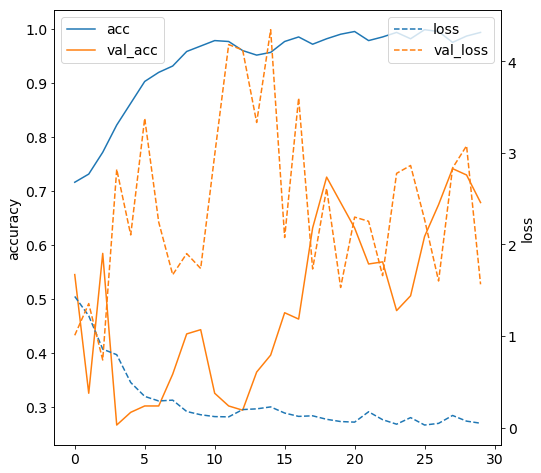

In [102]:
history_callback=model.fit(X_train__, y_train__,
                  epochs=30,
                  verbose=False,
                  validation_data=(X_val__, y_val__))

df = pd.DataFrame(history_callback.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
df[['loss', 'val_loss']].plot(linestyle='--', ax=plt.twinx())
plt.ylabel("loss");

In [103]:
train_acc=history_callback.history['acc'][-1]
train_loss=history_callback.history['loss'][-1]
val_acc=history_callback.history['val_acc'][-1]
val_loss=history_callback.history['val_loss'][-1]
print('train_acc =\t{}\ttrain_loss=\t{}\nval_acc =\t{}\tval_loss=\t{}\ntest_acc =\t{}\ttest_loss=\t{}'.format(round(train_acc,3),round(train_loss,3),round(val_acc,3),round(val_loss,3),round(testset_test[1],3),round(testset_test[0],3)))

train_acc =	0.993	train_loss=	0.049
val_acc =	0.678	val_loss=	1.565
test_acc =	0.684	test_loss=	4.266


In [104]:
#Train on the whole training set and test on the test set
history_callback=model.fit(X_train, y_train,
                  epochs=30,
                  verbose=False,
                    )
testset_test=model.evaluate(X_test,y_test)
print('test_acc =\t{}\ttest_loss=\t{}'.format(round(testset_test[1],3),round(testset_test[0],3)))

1000/1000 [==============================] - 19s 19ms/step
test_acc =	0.77	test_loss=	1.627


### Personal Image Blur Datase 

In [ ]:
#import training set
from keras.preprocessing import image
from os import listdir
from keras import utils

fdir='Data/CERTH_ImageBlurDataset/TrainingSet/Naturally-Blurred/'
files= listdir(fdir)
X=[] #feature vector
images_train=[]
Y=[] #class vector (1='blurred', 0='in focus')
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images_train.append(x)
    x=image.img_to_array(x)
    X.append(x)
    Y.append(int(1))
    
fdir='Data/CERTH_ImageBlurDataset/TrainingSet/Undistorted/'
files= listdir(fdir)
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images_train.append(x)
    x=image.img_to_array(x)
    X.append(x)
    Y.append(int(0))
    
X_train = np.array(X)
y_train = utils.to_categorical(Y, 2)

In [105]:
from keras.preprocessing import image
from os import listdir


fdir='Data/Personal_ImageBlurDataset/blurred/'
files= listdir(fdir)
X_test_P=[] #feature vector
images_test=[]
y_test_P=[] #class vector (1='blurred', 0='in focus')
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images_test.append(x)
    x=image.img_to_array(x)
    X_test_P.append(x)
    y_test_P.append(1)
    
fdir='Data/Personal_ImageBlurDataset/undistorted/'
files= listdir(fdir)
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images_test.append(x)
    x=image.img_to_array(x)
    X_test_P.append(x)
    y_test_P.append(0)
    
X_test_P = np.array(X_test_P)
y_test_P = utils.to_categorical(y_test_P, 2)

In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization

inputs = Input(shape=(224,224,3))
x = Conv2D(2, (3,3), activation='relu')(inputs)
x = Conv2D(5, (3,3), activation='relu')(x)
x = Conv2D(10, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
set_filter(horizontal_sobel_edge, vertical_sobel_edge)

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'],)

print(model.summary())

In [110]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 222, 222, 2)       56        
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 220, 220, 5)       95        
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 218, 218, 10)      460       
_________________________________________________________________
batch_normalization_28 (Batc (None, 218, 218, 10)      40        
_________________________________________________________________
flatten_28 (Flatten)         (None, 475240)            0         
_________________________________________________________________
dense_75 (Dense)             (None, 25)                11881025  
__________

In [109]:
#Train on the whole training set and test on the test set
#history_callback=model.fit(X_train, y_train,
#                  epochs=30,
#                  verbose=False,
#                    )
testset_test=model.evaluate(X_test_P,y_test_P)
print('test_acc =\t{}\ttest_loss=\t{}'.format(round(testset_test[1],3),round(testset_test[0],3)))

86/86 [==============================] - 2s 19ms/step
test_acc =	0.86	test_loss=	1.009


In [111]:
#Run with only the final dense layer
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization

inputs = Input(shape=(224,224,3))
x = Conv2D(2, (3,3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
set_filter(horizontal_sobel_edge, vertical_sobel_edge)

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'],)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 222, 222, 2)       56        
_________________________________________________________________
batch_normalization_29 (Batc (None, 222, 222, 2)       8         
_________________________________________________________________
flatten_29 (Flatten)         (None, 98568)             0         
_________________________________________________________________
dense_82 (Dense)             (None, 30)                2957070   
_________________________________________________________________
dense_83 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_84 (Dense)             (None, 30)                930       
__________

In [112]:
#Train on the whole training set and test on the test set
history_callback=model.fit(X_train, y_train,
                  epochs=30,
                  verbose=False,
                    )
testset_test=model.evaluate(X_test_P,y_test_P)
print('test_acc =\t{}\ttest_loss=\t{}'.format(round(testset_test[1],3),round(testset_test[0],3)))

86/86 [==============================] - 1s 17ms/step
test_acc =	0.674	test_loss=	3.844


In [113]:
history_callback.history['acc'][-1]

0.99882352941176467